# Gender Prediction using MobileNetV2

By Abhishek Chatterjee
(abhishekchatterjeejit@gmail.com)

**The aim of this project is to make a computer program to detect the gender of a person based on the single image of his/her face. This project is using the MobileNetV2 deep learning CNN architecture to predict it. The dataset that is used to train is a mix of the IMDB WIKI dataset and Selfie Dataset.**

## Dependencies

In the first step, we wil import the dependencies that we need for this project.

In [0]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications import MobileNetV2
from keras import optimizers

from sklearn.model_selection import train_test_split

## Connecting Google Drive

As I'm running it on Google Colab, and my dataset is stored into Google Drive, so I need to connect Colab with Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Unzipping the dataset

In Google Drive, the dataset is stored as a zip file. So before using it, I need to unzip it.

In [0]:
!unzip -qq 'drive/My Drive/dataset/imdb+wiki+selfie.zip' -d ./

There are three files in the dataset.


*   images/ folder - This folder contains the original images
*   gender.csv - This CSV file contains the meta information for the dataset (gender and image name)
*   age.csv - This CSV file contains the meta information for the age dataset (not needed here)



## Reading the Dataset

In this step, I will read the dataset, stored in CSV format. To read the dataset, I will use the pandas read_csv method.

Note: The entire the dataset is already preprocessed and cleaned. Please check the preprocessing code.

In [0]:
gender_data = pd.read_csv('./gender.csv')

# Fir testing im just using 10% of the data
# gender_data = gender_data.sample(frac=0.1)

## Analysing the Dataset

In this step, I will perform some basic analysis on the data

In [0]:
# Priting the first 10 rows of the dataset
gender_data.head()

,gender,path
0,Male,217452
1,Male,87590
2,Female,152842
3,Female,142937
4,Female,174618


In [0]:
# Printing the last 10 rows of the dataset
gender_data.tail()

,gender,path
268005,Male,14299
268006,Male,115428
268007,Male,110861
268008,Female,20448
268009,Male,128117


In [0]:
# Listing the column names
print(gender_data.columns)

Index(['gender', 'path'], dtype='object')


The column gender contains the gender label as Male and Female. And the column path contains the unique id of the images.

In [0]:
# Number of records present on the data
gender_data.shape

(268010, 2)

## Preprocessing the Dataset

Here I will perform some basic analysis of the dataset

In [0]:
# The path columns contains int values. I need to change it to string
gender_data = gender_data.astype({'gender' : str, 'path' : str})

# Add the .jpg image extension after the id of the image
gender_data['path'] = gender_data['path'] + '.jpg'

In [0]:
# Check the data again
gender_data.head()

,gender,path
0,Male,217452.jpg
1,Male,87590.jpg
2,Female,152842.jpg
3,Female,142937.jpg
4,Female,174618.jpg


## Checking the class balance 

In this step, I need to check the class balance of the dataset. If there is more samples for one class, then our model can be biased towards that class. To solve this problem, we need to use some type of sampling. 

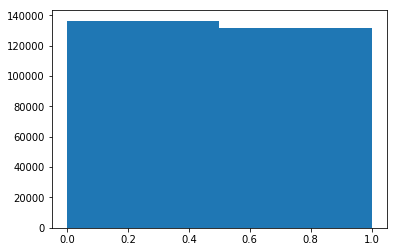

In [0]:
genders = []

for gender in gender_data['gender'].values:
  if gender == 'Male':
    genders.append(1)
  else:
    genders.append(0)

plt.hist(genders, 2)
plt.show()

Here there is almost equal number of samples for each class. So we dont need to do any sampling.

## Spliting the dataset

Here I will split the dataset into two parts, one for training and one for testing

In [0]:
train, test = train_test_split(gender_data, test_size=0.2, random_state=1969)

In [0]:
# Checking the data again
print(train.shape)
print(test.shape)

(214408, 2)
(53602, 2)


In [0]:
test.head()

,gender,path
52244,Female,124501.jpg
115944,Male,89004.jpg
190739,Female,239343.jpg
146862,Male,100387.jpg
112875,Male,111000.jpg


In [0]:
train.tail()

,gender,path
165838,Female,241271.jpg
85116,Female,233579.jpg
175392,Male,191392.jpg
213220,Male,167308.jpg
213779,Male,32744.jpg


## Generator Functions

The dataset in big, So we need to read the data in small batch. In Keras, ImageDataGenerator class provides a generator methods that we can use here.

In [0]:
# A generator object with some basic settings
generator = ImageDataGenerator(featurewise_center=False,
                               samplewise_center=False,  
                               featurewise_std_normalization=False,
                               samplewise_std_normalization=False,
                               zca_whitening=False,
                               rotation_range=10,  
                               zoom_range = 0.1, 
                               width_shift_range=0.1,  
                               height_shift_range=0.1,
                               horizontal_flip=True,  
                               vertical_flip=False)  

In [0]:
# Now I will read the dataset using the generator 
train_gen = generator.flow_from_dataframe(train, 
                                          directory='images/',
                                          x_col='path',
                                          y_col='gender',
                                          target_size=(224,224),
                                          batch_size=64)

Found 214408 validated image filenames belonging to 2 classes.


In [0]:
test_gen = generator.flow_from_dataframe(test, 
                                         directory='images/',
                                         x_col='path',
                                         y_col='gender',
                                         target_size=(224,224),
                                         batch_size=64)

Found 53602 validated image filenames belonging to 2 classes.


## Model

Here I will make the MobileNetV2 model

In [0]:
model = Sequential()

# Im initializing the model with imagenet weighs
mobile = MobileNetV2(include_top=False,
                     weights="imagenet", 
                     input_shape=(224,224,3),
                     pooling="max")

model.add(mobile)
model.add(Dense(units=2, activation="softmax"))

In [0]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['accuracy'])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 1280)              2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,226,434
Non-trainable params: 34,112
_________________________________________________________________


## Training the Model

Here I will train the model with the dataset

In [0]:
STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_TEST=test_gen.n//test_gen.batch_size

history = model.fit_generator(train_gen,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=test_gen,
                              validation_steps=STEP_SIZE_TEST,
                              epochs=3)

Epoch 1/3
3350/3350 [==============================] - 3226s 963ms/step - loss: 0.5380 - acc: 0.8245 - val_loss: 0.3963 - val_acc: 0.8656
Epoch 2/3
3350/3350 [==============================] - 3164s 945ms/step - loss: 0.3298 - acc: 0.8728 - val_loss: 0.2936 - val_acc: 0.8951
Epoch 3/3
3350/3350 [==============================] - 3061s 914ms/step - loss: 0.2684 - acc: 0.8961 - val_loss: 0.2533 - val_acc: 0.9052


## Ploting Training Graphs 

Plotting training graphs to analyse the performence

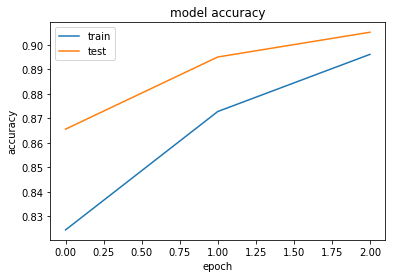

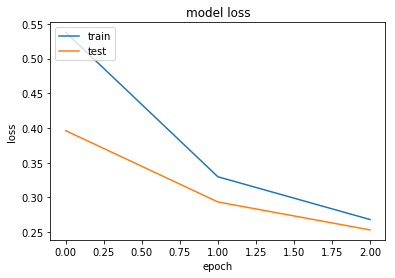

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
model.save('weights.h5')